<a href="https://colab.research.google.com/github/jordanbell2357/uscg-nais-data/blob/main/BigQuery/mmsi_219155000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'ais-data-385301' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=ais-data-385301:US:bquxjob_26f1c9e6_188746623e6)
back to BigQuery to edit the query within the BigQuery user interface.

In [9]:
# Running this code will display the query used to generate your previous job

job = client.get_job('bquxjob_26f1c9e6_188746623e6') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT * FROM `ais-data-385301.uscg.nais` WHERE MMSI = '219155000' ORDER BY BaseDateTime ASC;



# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [15]:
# Running this code will read results from your previous job

job = client.get_job('bquxjob_26f1c9e6_188746623e6') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,219155000,2022-06-03 20:14:39+00:00,36.84612,-128.70643,1.6,93.4,169.0,MAERSK EVORA,IMO9458080,OXVS2,70,0,366.0,48.0,15.5,71,A
1,219155000,2022-06-04 00:57:28+00:00,36.83643,-128.55005,1.4,89.8,146.0,MAERSK EVORA,IMO9458080,OXVS2,70,0,366.0,48.0,15.5,71,A
2,219155000,2022-06-04 00:58:40+00:00,36.83642,-128.54945,1.4,91.7,146.0,MAERSK EVORA,IMO9458080,OXVS2,70,0,366.0,48.0,15.5,71,A
3,219155000,2022-06-04 00:59:58+00:00,36.83640,-128.54879,1.4,91.6,146.0,MAERSK EVORA,IMO9458080,OXVS2,70,0,366.0,48.0,15.5,71,A
4,219155000,2022-06-04 01:00:58+00:00,36.83641,-128.54828,1.4,90.3,146.0,MAERSK EVORA,IMO9458080,OXVS2,70,0,366.0,48.0,15.5,71,A


In [11]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18973 entries, 0 to 18972
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   MMSI              18973 non-null  object             
 1   BaseDateTime      18973 non-null  datetime64[ns, UTC]
 2   LAT               18973 non-null  float64            
 3   LON               18973 non-null  float64            
 4   SOG               18973 non-null  float64            
 5   COG               18973 non-null  float64            
 6   Heading           18973 non-null  float64            
 7   VesselName        18973 non-null  object             
 8   IMO               18973 non-null  object             
 9   CallSign          18973 non-null  object             
 10  VesselType        18973 non-null  object             
 11  Status            18973 non-null  object             
 12  Length            18973 non-null  float64            
 13  W

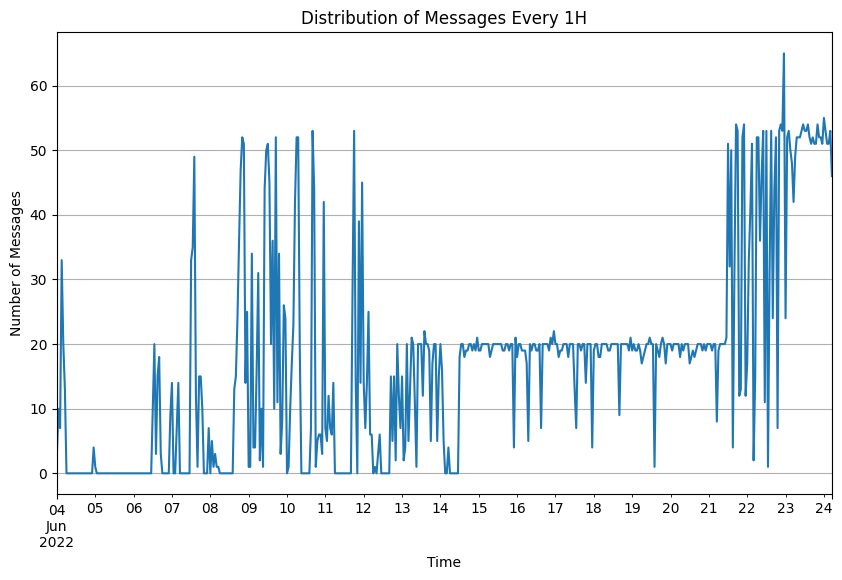

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
start_date = pd.Timestamp('2022-06-01')
end_date = pd.Timestamp('2022-07-31')
interval_length = '1H'  # Options: '1min', '5min', '10min', '15min', '30min', '1H', '2H', '3H', ...

df = results[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading']].copy()
df['BaseDateTime'] = df['BaseDateTime'].dt.tz_convert('UTC').dt.tz_localize(None)
df.set_index('BaseDateTime', inplace=True)

# Calculate the time differences in seconds
df['TimeDifference'] = df.index.to_series().diff().dt.total_seconds()

# Remove the first row (NaN value for 'TimeDifference')
df = df.iloc[1:]

# Apply date range filter
df_filtered = df.loc[start_date:end_date]

if df_filtered.empty:
    print("No data points between '2022-06-01' and '2022-08-31'")
else:
    # Count messages by each interval
    message_counts_by_interval = df_filtered.resample(interval_length).count()['MMSI']

    # Plot the result
    plt.figure(figsize=(10, 6))
    message_counts_by_interval.plot()
    plt.xlabel('Time')
    plt.ylabel('Number of Messages')
    plt.title(f'Distribution of Messages Every {interval_length}')
    plt.grid(True)
    plt.show()


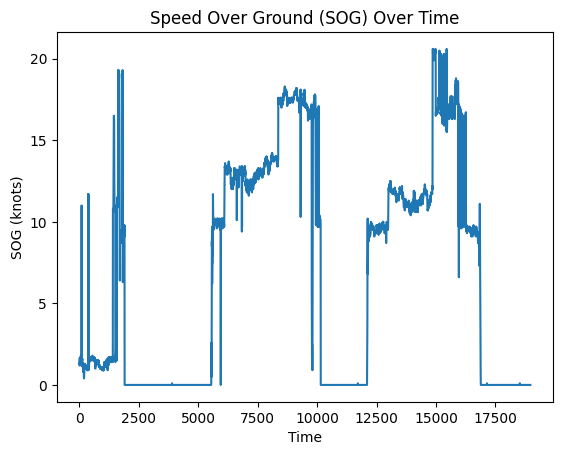

In [25]:
import matplotlib.pyplot as plt

# Assuming 'BaseDateTime' is the index of your DataFrame
results['SOG'].plot(kind='line')
plt.title('Speed Over Ground (SOG) Over Time')
plt.xlabel('Time')
plt.ylabel('SOG (knots)')
plt.show()


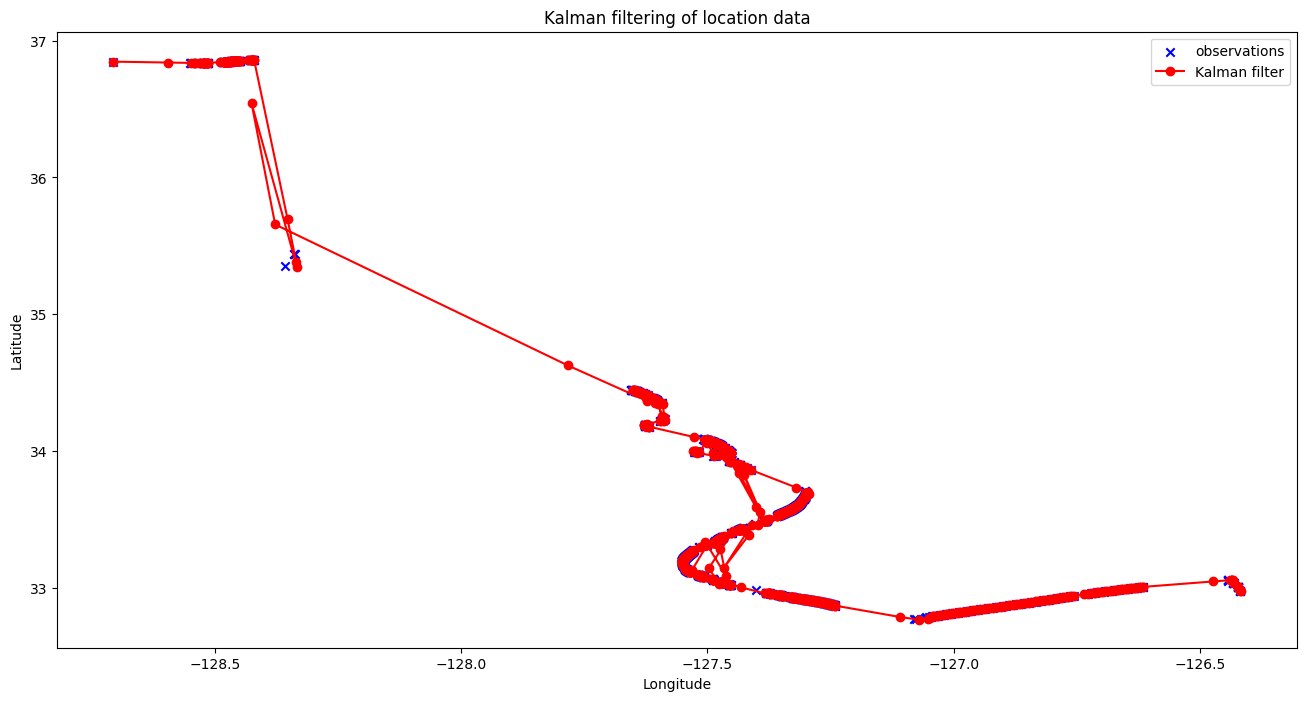

In [13]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Set start and end timestamps for the analysis
start_date = pd.Timestamp('2022-06-01 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-06-10 23:00:00')  # Include the desired hour

df = results[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading']].copy()
df['BaseDateTime'] = df['BaseDateTime'].dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df_filtered = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)]

# Set BaseDateTime as index for filtered dataframe
df_filtered.set_index('BaseDateTime', inplace=True)

# Convert DataFrame to numpy array
coordinates = df_filtered[['LAT', 'LON']].to_numpy()

# Specify initial state mean and covariance
initial_state_mean = [coordinates[0, 0],
                      0,
                      coordinates[0, 1],
                      0]

initial_state_covariance = [[1, 0, 0, 0], 
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]

# Create a Kalman Filter instance
kf = KalmanFilter(transition_matrices=[[1, 1, 0, 0], 
                                        [0, 1, 0, 0],
                                        [0, 0, 1, 1],
                                        [0, 0, 0, 1]],
                   observation_matrices=[[1, 0, 0, 0], 
                                         [0, 0, 1, 0]],
                   initial_state_mean=initial_state_mean,
                   initial_state_covariance=initial_state_covariance)

# Perform the Kalman filtering
mean_states, covariances = kf.filter(coordinates)

# Visualize the results
plt.figure(figsize=(16, 8))
plt.scatter(coordinates[:, 1], coordinates[:, 0], marker='x', color='b', label='observations')
plt.plot(mean_states[:, 2], mean_states[:, 0], linestyle='-', marker='o', color='r', label='Kalman filter')
plt.legend()
plt.title('Kalman filtering of location data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

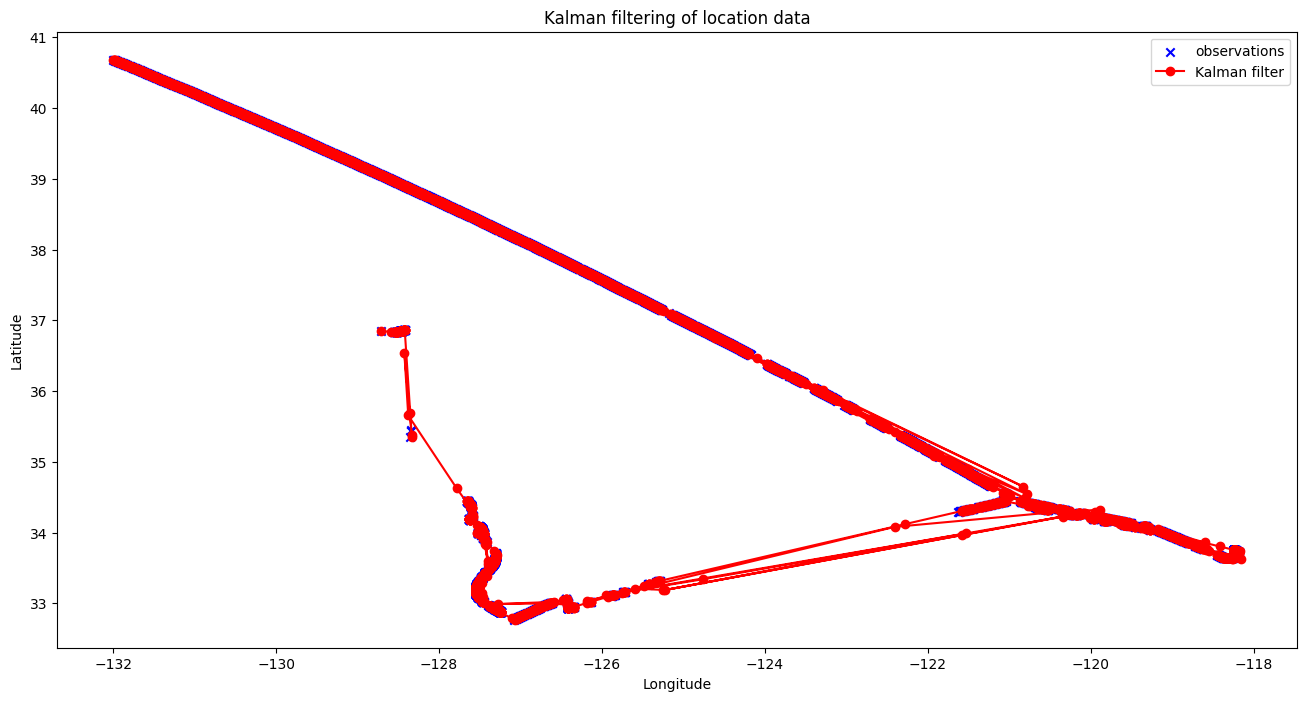

In [19]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Set start and end timestamps for the analysis
start_date = pd.Timestamp('2022-06-01 00:00:00')  # Include the desired hour
end_date = pd.Timestamp('2022-07-31 23:00:00')  # Include the desired hour

df = results[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading']].copy()
df['BaseDateTime'] = df['BaseDateTime'].dt.tz_convert('UTC').dt.tz_localize(None)

# Apply time cutoff
df_filtered = df[(df['BaseDateTime'] >= start_date) & (df['BaseDateTime'] <= end_date)]

# Set BaseDateTime as index for filtered dataframe
df_filtered.set_index('BaseDateTime', inplace=True)

# Convert DataFrame to numpy array
coordinates = df_filtered[['LAT', 'LON']].to_numpy()

# Specify initial state mean and covariance
initial_state_mean = [coordinates[0, 0],
                      0,
                      coordinates[0, 1],
                      0]

initial_state_covariance = [[1, 0, 0, 0], 
                            [0, 1, 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]]

# Create a Kalman Filter instance
kf = KalmanFilter(transition_matrices=[[1, 1, 0, 0], 
                                        [0, 1, 0, 0],
                                        [0, 0, 1, 1],
                                        [0, 0, 0, 1]],
                   observation_matrices=[[1, 0, 0, 0], 
                                         [0, 0, 1, 0]],
                   initial_state_mean=initial_state_mean,
                   initial_state_covariance=initial_state_covariance)

# Perform the Kalman filtering
mean_states, covariances = kf.filter(coordinates)

# Visualize the results
plt.figure(figsize=(16, 8))
plt.scatter(coordinates[:, 1], coordinates[:, 0], marker='x', color='b', label='observations')
plt.plot(mean_states[:, 2], mean_states[:, 0], linestyle='-', marker='o', color='r', label='Kalman filter')
plt.legend()
plt.title('Kalman filtering of location data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

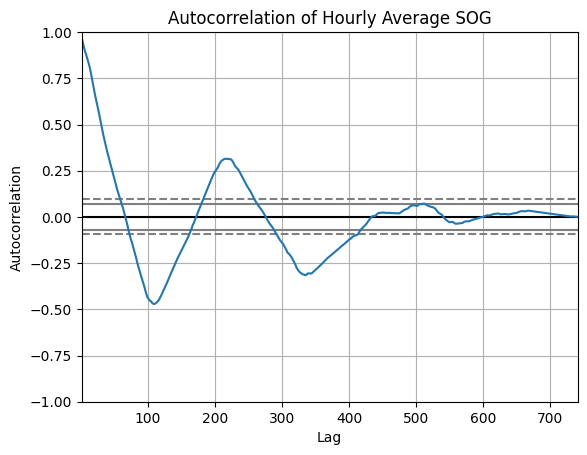

In [27]:
from pandas.plotting import autocorrelation_plot

df = results.copy()

# Convert 'BaseDateTime' to datetime format if it's not already
if not isinstance(df['BaseDateTime'].dtype, pd.DatetimeTZDtype):
    df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])

# Set 'BaseDateTime' as index if it's not already
if not isinstance(df.index, pd.DatetimeIndex):
    df.set_index('BaseDateTime', inplace=True)

# Create a new DataFrame with hourly mean SOG
hourly = df['SOG'].resample('1H').mean()

# Drop any NaN values
hourly = hourly.dropna()

autocorrelation_plot(hourly)
plt.title('Autocorrelation of Hourly Average SOG')
plt.show()

In [29]:
import movingpandas as mpd
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

df = results[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading']].copy()
df.set_index('BaseDateTime', inplace=True)

# Convert your DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT), crs="EPSG:4326")

# Create a TrajectoryCollection from the GeoDataFrame
traj_collection = mpd.TrajectoryCollection(gdf, 'MMSI')

# You can adjust these parameters as needed:
MIN_LENGTH = 1000  # meters
MIN_DURATION = pd.Timedelta(minutes=60)  # minimum duration of a trip
SPEED = 2  # speed threshold for being considered stationary, in knots

# Segment trajectories into trips
trips = []
for traj in traj_collection:
    splitter = mpd.SpeedSplitter(traj)
    segments = splitter.split(speed=SPEED, duration=MIN_DURATION)

    # Remove short segments
    long_segments = [segment for segment in segments if segment.get_length() > MIN_LENGTH]

    trips.extend(long_segments)

# Now 'trips' is a list of Trajectory objects, each one represents a "trip"
#for trip in trips:
#    print(trip)

/usr/local/lib/python3.10/dist-packages/movingpandas/trajectory.py:136: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(


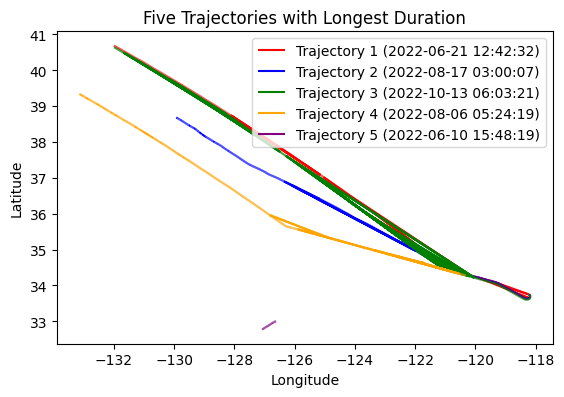

In [31]:
import matplotlib.pyplot as plt

# Sort trips by duration in descending order
trips.sort(key=lambda x: x.get_duration(), reverse=True)

# Select the top 5 longest duration trips
top_5_trips = trips[:5]

# Create a figure and axes
fig, ax = plt.subplots()

# Assign colors to trajectories
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot each trajectory with a different color and add legend
for i, trip in enumerate(top_5_trips):
    color = colors[i]
    trip.plot(ax=ax, color=color, label=f"Trajectory {i+1} ({trip.get_start_time().strftime('%Y-%m-%d %H:%M:%S')})")

# Set plot title and labels
ax.set_title("Five Trajectories with Longest Duration")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add legend
ax.legend()

# Show the plot
plt.show()
